In [1]:
import json
import time
from itertools import cycle

import gensim
import jieba
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import manifold
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth, Birch
from sklearn import decomposition
from sklearn.neighbors import kneighbors_graph
import matplotlib.colors as colors
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
stop_word_set = set()
with open(r'./stopwords.txt', 'r', encoding='utf-8') as sw:
    for line in sw:
        stop_word_set.add(line.strip('\n'))

In [3]:
with open("content.json") as f:
    data_dict=json.load(f)

In [4]:
data = data_dict["content"]

In [76]:
data[384]


'提前 入伍 簽約 時 沒想到 改變 休學 當兵 簽約 時間 去年 月 合約終止 日為 年 月 剛剛 合約 裡面 提到 提前 解約 照理說 註明 一條 提前 解約 需付 違約金 月租金 合約 只 註明 提前 解約 需 另一方 同意 提前 解約 發現 合約 註明 解約 要付 違約金 照裡 說 是不是 違約金 房東 說 租 長期 突然 當兵 是不是 當兵 事實 房東 說 解約 意思 付 月 違約金 有付 月 押金 節 清水 電費 清空 房子 房東 解約 每月 日前 繳 房租 月付'

In [6]:
Lsent = gensim.models.doc2vec.LabeledSentence
def labelizeNews(News, label_type):
    labelized = []
    #enumertate include index
    for i, v in enumerate(News):
        label = '%s_%s' %(label_type,i)
        labelized.append(Lsent(v, [label]))
    return labelized

In [8]:
size = 400   
model_dm = gensim.models.Doc2Vec(size=size, sample=1e-3, workers=3)
model_dbow = gensim.models.Doc2Vec( size=size, sample=1e-3,dm=0, workers=3)
train = labelizeNews(data,'train')
model_dm.build_vocab(train)
model_dbow.build_vocab(train)

In [9]:
for epoch in range(10):
    perm = np.random.permutation(len(train))
    model_dm.train([train[x] for x in perm], total_examples=model_dm.corpus_count, epochs=model_dm.iter)
    model_dbow.train([train[x] for x in perm], total_examples=model_dbow.corpus_count, epochs=model_dbow.iter)

In [14]:
# model_dm.save(r'model_dm')
# model_dbow.save(r'model_dbow')

In [43]:
# model_dm = model_dm.load(r'model_dm')
# model_dbow =model_dbow.load(r'model_dbow')

In [10]:
def getVecs(model, corpus, size):
    vecs = [model.docvecs[z.tags[0]].reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)

In [11]:
Train_vecs_dm = getVecs(model_dm, train, size)
Train_vecs_dbow = getVecs(model_dbow, train, size)
train_vecs = np.hstack((Train_vecs_dm, Train_vecs_dbow))

In [88]:
train_vecs

array([[ 1.14918959,  1.46825576, -1.2614857 , ..., -0.16434786,
         0.08480673, -0.21211867],
       [-1.53424156, -0.25429747,  0.60192972, ..., -0.01789118,
        -0.58511996, -0.07985904],
       [ 0.29405433,  0.75722396,  0.87648082, ...,  0.68765128,
        -0.29992175, -0.21468225],
       ..., 
       [ 0.67789   ,  1.2228694 , -0.4139441 , ..., -0.24839625,
        -0.09048203, -0.06565782],
       [ 0.59973252,  0.17477095,  0.83743024, ..., -0.57609928,
         0.06551392, -0.03636839],
       [-0.34692162, -0.35152501,  0.1709787 , ...,  0.27784452,
         0.30282485, -0.01820636]], dtype=float32)

In [13]:
#固定random state 隨機初始值 fixed the seed
All_kmeans = KMeans(n_clusters=5, random_state=0).fit(train_vecs)

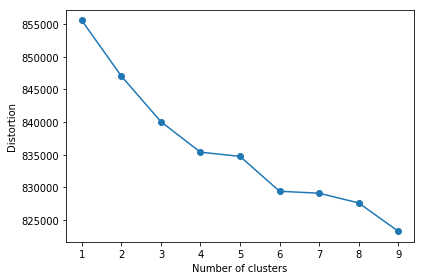

In [80]:
distortions = []
sup = 10
for i in range(1, sup):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(train_vecs)
    distortions.append(km.inertia_)
plt.plot(range(1, sup), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

In [16]:
kmean_10 = KMeans(n_clusters=10, random_state=0).fit(train_vecs)

In [17]:
X= pd.read_csv('./data_lable.csv')

In [18]:
X.insert(0, "Cluster", All_kmeans.labels_)

In [19]:
len(train_vecs)

4418

In [20]:
X.head()

,Cluster,Unnamed: 0,lable,_id,article_id,author,board,comments,comments_count,content,date,ip,rate,title,url
0,2,0,"{'租金問題', '環境問題', '合約問題'}",599aac7faadaed95a0f57f5b,M.1255571810.A.474,m330jjj,rent-exp,"[{'push_content': ':請他找到人頂替 不然不退11月的錢', 'push_...","{'total_count': 5, 'boo': 0, 'push': 1, 'neutr...",───────────────────────────────────────我的情況是這樣...,2009-10-15,NaN,1,[金錢] 我該怎麼做?,https://www.ptt.cc/bbs/rent-exp/M.1255571810.A...
1,0,1,"{'租金問題', '合約問題'}",599aac7faadaed95a0f57f5d,M.1255587087.A.575,parkview,rent-exp,"[{'push_content': ':合約都簽了就照合約走 出去的錢應該回不來', 'pu...","{'total_count': 11, 'boo': 0, 'push': 3, 'neut...",這是我學妹發生的問題 事情是這樣的我一個大一學妹租了我隔壁的一間單人套房房租一個月一萬 押金...,2009-10-15,NaN,3,[金錢] 合約簽了還沒住進去房租應該被扣嗎?,https://www.ptt.cc/bbs/rent-exp/M.1255587087.A...
2,0,2,"{'糾紛', '租金問題'}",599aac7faadaed95a0f57f5e,M.1255611415.A.1F3,jusie,rent-exp,[{'push_content': ':他的詩肯柚木椅很新嗎？如果是舊的、原本就有刮痕，那要...,"{'total_count': 9, 'boo': 0, 'push': 4, 'neutr...","板上的大家好: 預計十月底搬走, 十月的房租已付清, 十月十一日告知房東,...",2009-10-15,NaN,4,[金錢] 房東不退押金 我該怎麼辦,https://www.ptt.cc/bbs/rent-exp/M.1255611415.A...
3,0,3,"{'租金問題', '環境問題'}",599aac7faadaed95a0f57f5f,M.1255615113.A.FCC,dondon0419,rent-exp,"[{'push_content': ':找長輩或朋友陪你去談，比較安全哦', 'push_i...","{'total_count': 2, 'boo': 0, 'push': 2, 'neutr...",我7月1號搬出舊的地方然後因為還要扣水電所以押金就沒有拿結果拖到今天我忍不住打電話去問他居然...,2009-10-15,NaN,2,[金錢] 誇張的房東,https://www.ptt.cc/bbs/rent-exp/M.1255615113.A...
4,2,4,{'環境問題'},599aac7faadaed95a0f57f61,M.1255617703.A.A44,oarp,rent-exp,"[{'push_content': ':可參考DEATH NOTE', 'push_ipda...","{'total_count': 21, 'boo': 0, 'push': 6, 'neut...",住進目前的房子已經快一個月了~~期間有幾次有意無意的知道房東曾經未告知就進過我的房間例如 房...,2009-10-15,NaN,6,[房東] 想測試房東到底有沒有進來過,https://www.ptt.cc/bbs/rent-exp/M.1255617703.A...


In [21]:
X['lable']

0       {'租金問題', '環境問題', '合約問題'}
1               {'租金問題', '合約問題'}
2                 {'糾紛', '租金問題'}
3               {'租金問題', '環境問題'}
4                       {'環境問題'}
5                       {'租金問題'}
6               {'租金問題', '環境問題'}
7                       {'租金問題'}
8                       {'租金問題'}
9                       {'租金問題'}
10              {'租金問題', '房屋問題'}
11              {'租金問題', '房屋問題'}
12                      {'租金問題'}
13                        {None}
14                      {'租金問題'}
15                      {'環境問題'}
16                      {'租金問題'}
17              {'租金問題', '合約問題'}
18              {'租金問題', '環境問題'}
19                        {None}
20              {'租金問題', '房屋問題'}
21                      {'租金問題'}
22                        {None}
23                      {'合約問題'}
24                        {None}
25                      {'合約問題'}
26                        {None}
27                      {'合約問題'}
28                      {'合約問題'}
29              {'租金問題', '合約問題'}
          

In [22]:
X['lable'].value_counts() 

{None}                                  1081
{'租金問題'}                                 692
{'租金問題', '合約問題'}                         614
{'合約問題'}                                 573
{'房屋問題'}                                 254
{'環境問題'}                                 177
{'租金問題', '房屋問題'}                         124
{'租金問題', '環境問題'}                         105
{'環境問題', '合約問題'}                          77
{'房屋問題', '合約問題'}                          65
{'糾紛'}                                    63
{'糾紛', '租金問題', '合約問題'}                    61
{'糾紛', '合約問題'}                            52
{'租金問題', '房屋問題', '合約問題'}                  44
{'糾紛', '租金問題'}                            42
{'租金問題', '環境問題', '合約問題'}                  39
{'治安'}                                    33
{'環境問題', '租金問題', '合約問題'}                  25
{'稅務問題', '合約問題'}                          20
{'糾紛', '房屋問題'}                            19
{'環境問題', '房屋問題'}                          18
{'稅務問題'}                                  18
{'稅務問題', '

In [23]:
X['Cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

0    2003
2     968
3     842
1     604
4       1
Name: Cluster, dtype: int64

In [24]:
grouped = X["lable"].groupby(X['Cluster'])

In [25]:
grouped.all()

Cluster
0    {'租金問題', '合約問題'}
1      {'糾紛', '租金問題'}
2            {'房屋問題'}
3    {'租金問題', '合約問題'}
4            {'環境問題'}
Name: lable, dtype: object

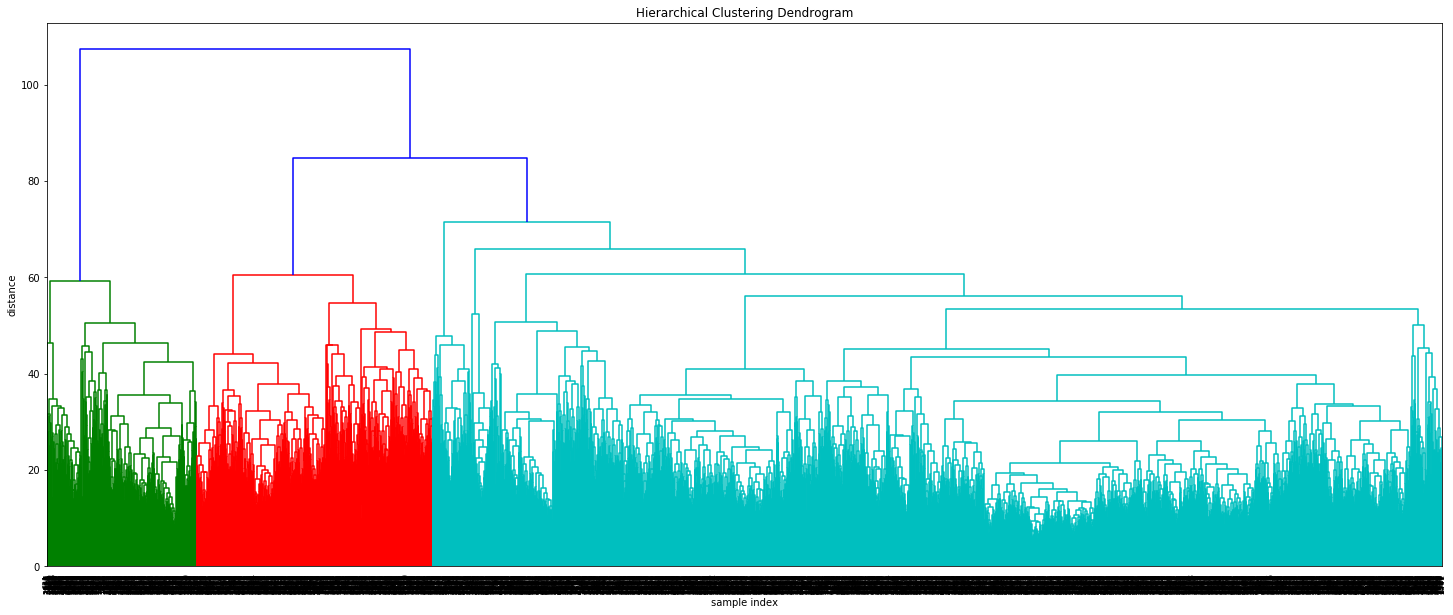

In [30]:
# Hierarchical Clustering
Z = linkage(train_vecs, 'ward')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

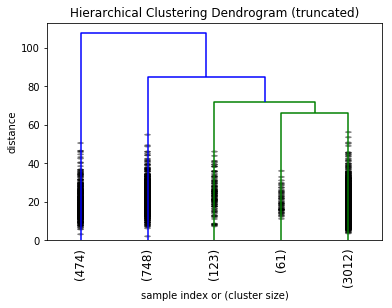

In [28]:
# 5 truncated
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=5,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

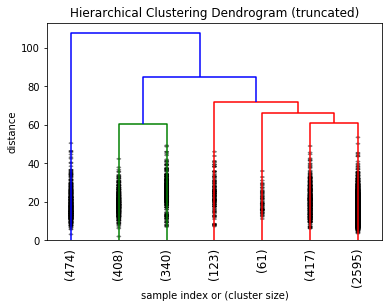

In [32]:
# 7 truncated
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=7,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

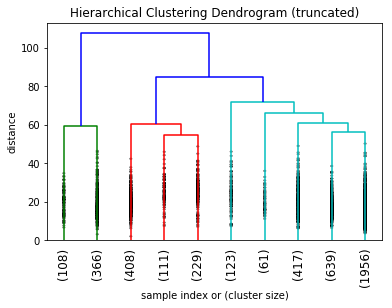

In [33]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [34]:
def plot_clustering(X, labels, title=None):
    plt.figure(figsize=(6, 4))
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=plt.cm.spectral(labels[i] / 10.))

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [35]:
# 降維(PCA)至二維
pca = decomposition.PCA(n_components=2)
X1= pca.fit_transform(train_vecs)

In [36]:
# 降維(SpectralEmbedding, non-linear)至二維
X2 = manifold.SpectralEmbedding(n_components=2).fit_transform(train_vecs)

In [37]:
# 降維(t-SNE, non-linear)至二維
X3 = manifold.TSNE(n_components=2).fit_transform(train_vecs)

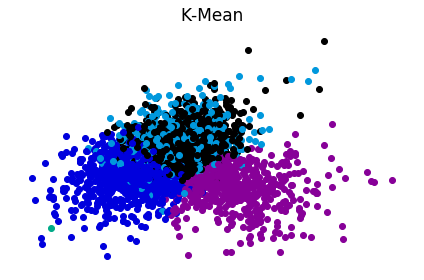

In [38]:
# K-Mean(PCA)
plot_clustering(X1, All_kmeans.labels_, "K-Mean")

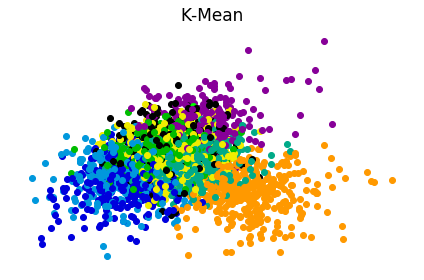

In [40]:
plot_clustering(X1, kmean_10.labels_, "K-Mean")

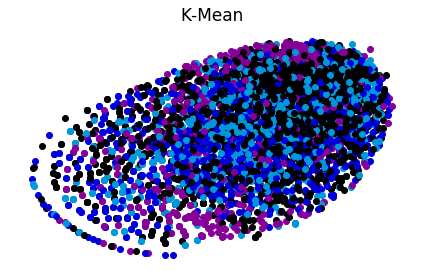

In [41]:
# K-Mean(t-SNE)
plot_clustering(X3, All_kmeans.labels_, "K-Mean")

In [42]:
# Hierarchical Clustering
Hclustering = AgglomerativeClustering(n_clusters=5,
 affinity="euclidean", linkage="ward")

In [43]:
HC = Hclustering.fit(train_vecs)

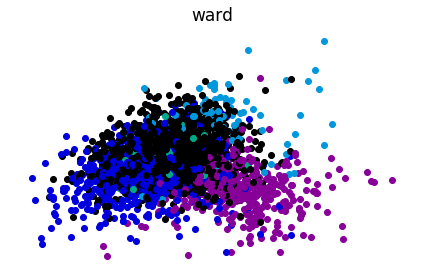

In [44]:
# PCA
plot_clustering(X1, HC.labels_, "ward")

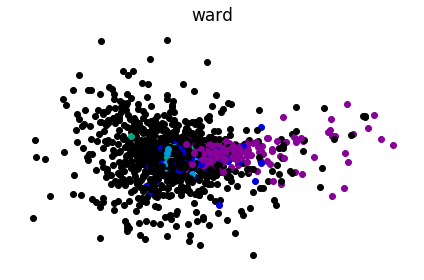

In [45]:
# SpectralEmbedding
plot_clustering(X2, HC.labels_, "ward")

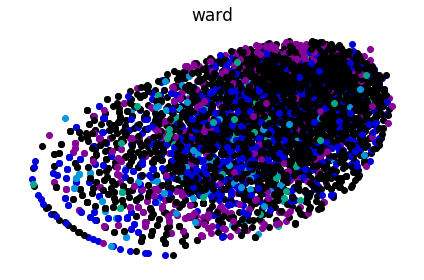

In [46]:
# t-SNE
plot_clustering(X3, HC.labels_, "ward")

In [47]:
X.insert(1, "Cluster2", HC.labels_)

In [48]:
X['Cluster2'].value_counts() 

0    3012
2     748
1     474
3     123
4      61
Name: Cluster2, dtype: int64

In [49]:
grouped2 = X["lable"].groupby(X['Cluster2'])
grouped2.all()

Cluster2
0          {'租金問題', '合約問題'}
1            {'糾紛', '租金問題'}
2          {'租金問題', '合約問題'}
3    {'糾紛', '租金問題', '合約問題'}
4                    {None}
Name: lable, dtype: object

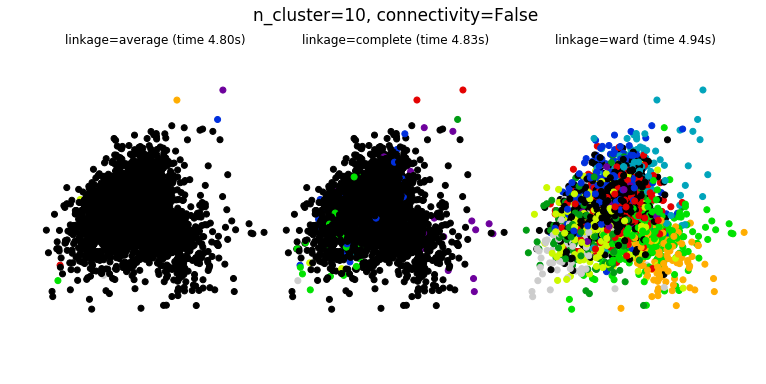

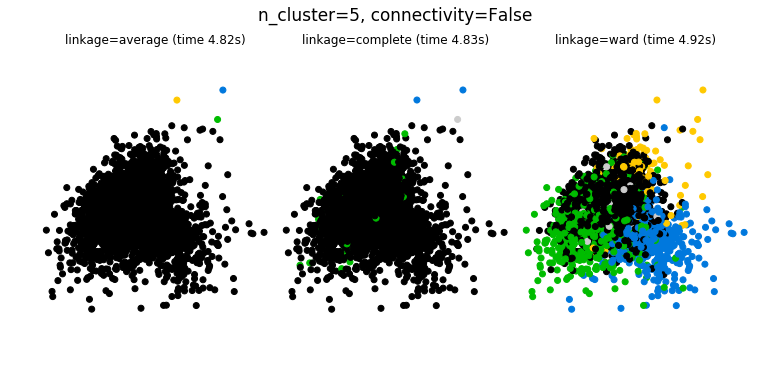

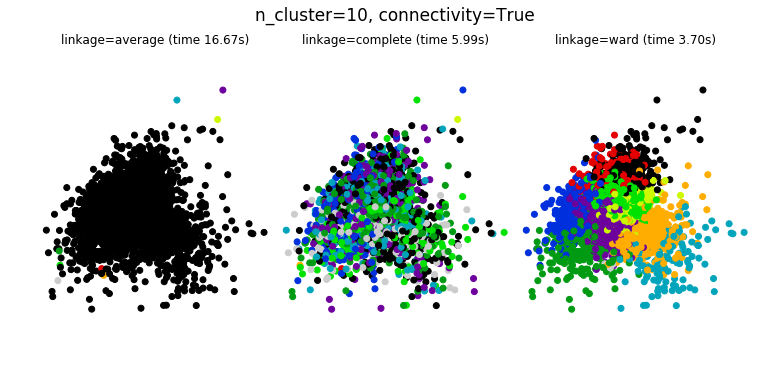

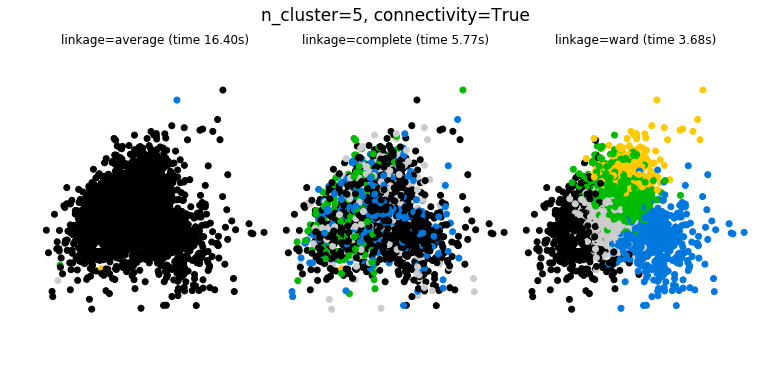

In [50]:
# Hierarchical Clustering group=(5, 10), different linkage_method, connectivity (PCA)
knn_graph = kneighbors_graph(X1, 30, include_self=False)
for connectivity in (None, knn_graph):
    for n_clusters in (10, 5):
        plt.figure(figsize=(10, 5))
        for index, linkage_method in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage_method,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(train_vecs)
            elapsed_time = time.time() - t0
            plt.scatter(X1[:, 0], X1[:, 1], c=model.labels_,
                        cmap=plt.cm.spectral)
            plt.title('linkage=%s (time %.2fs)' % (linkage_method, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

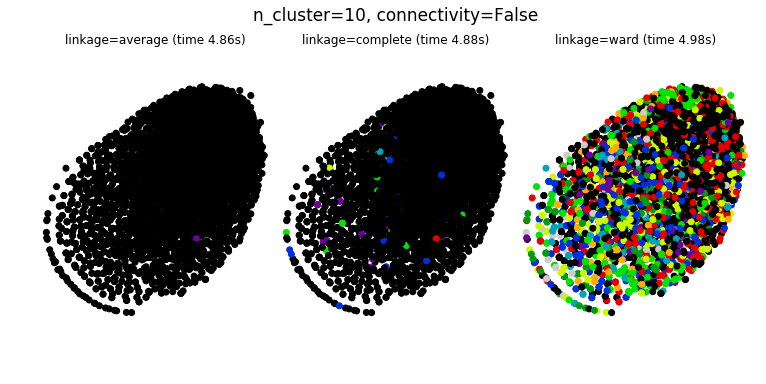

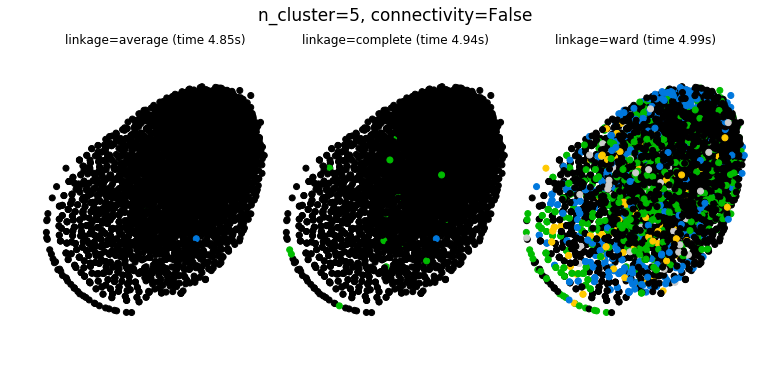

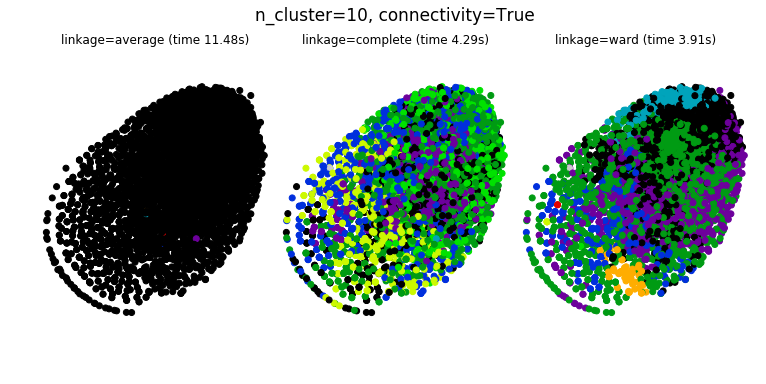

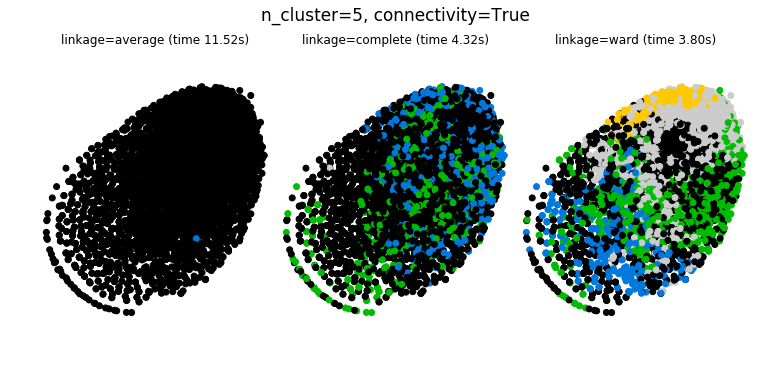

In [51]:
# Hierarchical Clustering group=(5, 10), different linkage_method, connectivity (t-SNE)
knn_graph = kneighbors_graph(X3, 30, include_self=False)
for connectivity in (None, knn_graph):
    for n_clusters in (10, 5):
        plt.figure(figsize=(10, 5))
        for index, linkage_method in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage_method,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(train_vecs)
            elapsed_time = time.time() - t0
            plt.scatter(X3[:, 0], X3[:, 1], c=model.labels_,
                        cmap=plt.cm.spectral)
            plt.title('linkage=%s (time %.2fs)' % (linkage_method, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

number of estimated clusters : 1


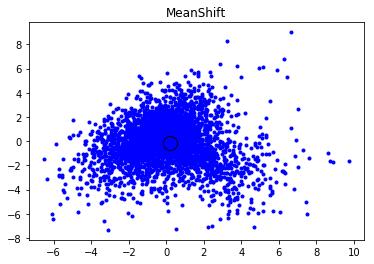

In [52]:
bandwidth = estimate_bandwidth(train_vecs, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(train_vecs)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X1[my_members, 0], X1[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('MeanShift')
plt.show()

In [191]:
# X.insert(2, "Cluster3", ms.labels_)
# X['Cluster3'].value_counts() 

0    4209
1     156
2      45
3       6
4       1
Name: Cluster3, dtype: int64

In [193]:
# grouped3 = X["lable"].groupby(X['Cluster3'])
# grouped3.all()

Cluster3
0                    {'糾紛', '租金問題'}
1                          {'租金問題'}
2                          {'租金問題'}
3                            {'糾紛'}
4    {'糾紛', '房屋問題', '合約問題', '租金問題'}
Name: lable, dtype: object

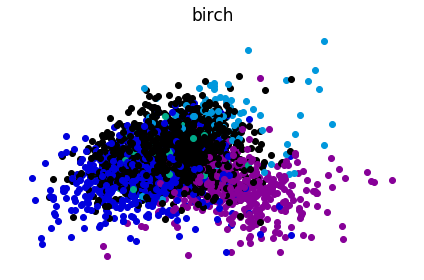

In [53]:
# birch
n_clusters = 5
birch = Birch(n_clusters=n_clusters)
birch.fit_transform(train_vecs)
plot_clustering(X1, birch.labels_, "birch")

In [54]:
X.insert(2, "Cluster3", birch.labels_)
X['Cluster3'].value_counts()

0    3012
2     748
1     474
3     123
4      61
Name: Cluster3, dtype: int64

In [55]:
grouped3 = X["lable"].groupby(X['Cluster3'])
grouped3.all()

Cluster3
0          {'租金問題', '合約問題'}
1            {'糾紛', '租金問題'}
2          {'租金問題', '合約問題'}
3    {'糾紛', '租金問題', '合約問題'}
4                    {None}
Name: lable, dtype: object

In [61]:
X

,Cluster,Cluster2,Cluster3,Cluster4,Unnamed: 0,lable,_id,article_id,author,board,comments,comments_count,content,date,ip,rate,title,url
0,2,2,2,4,0,"{'租金問題', '環境問題', '合約問題'}",599aac7faadaed95a0f57f5b,M.1255571810.A.474,m330jjj,rent-exp,"[{'push_content': ':請他找到人頂替 不然不退11月的錢', 'push_...","{'total_count': 5, 'boo': 0, 'push': 1, 'neutr...",───────────────────────────────────────我的情況是這樣...,2009-10-15,NaN,1,[金錢] 我該怎麼做?,https://www.ptt.cc/bbs/rent-exp/M.1255571810.A...
1,0,0,0,0,1,"{'租金問題', '合約問題'}",599aac7faadaed95a0f57f5d,M.1255587087.A.575,parkview,rent-exp,"[{'push_content': ':合約都簽了就照合約走 出去的錢應該回不來', 'pu...","{'total_count': 11, 'boo': 0, 'push': 3, 'neut...",這是我學妹發生的問題 事情是這樣的我一個大一學妹租了我隔壁的一間單人套房房租一個月一萬 押金...,2009-10-15,NaN,3,[金錢] 合約簽了還沒住進去房租應該被扣嗎?,https://www.ptt.cc/bbs/rent-exp/M.1255587087.A...
2,0,0,0,8,2,"{'糾紛', '租金問題'}",599aac7faadaed95a0f57f5e,M.1255611415.A.1F3,jusie,rent-exp,[{'push_content': ':他的詩肯柚木椅很新嗎？如果是舊的、原本就有刮痕，那要...,"{'total_count': 9, 'boo': 0, 'push': 4, 'neutr...","板上的大家好: 預計十月底搬走, 十月的房租已付清, 十月十一日告知房東,...",2009-10-15,NaN,4,[金錢] 房東不退押金 我該怎麼辦,https://www.ptt.cc/bbs/rent-exp/M.1255611415.A...
3,0,0,0,0,3,"{'租金問題', '環境問題'}",599aac7faadaed95a0f57f5f,M.1255615113.A.FCC,dondon0419,rent-exp,"[{'push_content': ':找長輩或朋友陪你去談，比較安全哦', 'push_i...","{'total_count': 2, 'boo': 0, 'push': 2, 'neutr...",我7月1號搬出舊的地方然後因為還要扣水電所以押金就沒有拿結果拖到今天我忍不住打電話去問他居然...,2009-10-15,NaN,2,[金錢] 誇張的房東,https://www.ptt.cc/bbs/rent-exp/M.1255615113.A...
4,2,2,2,6,4,{'環境問題'},599aac7faadaed95a0f57f61,M.1255617703.A.A44,oarp,rent-exp,"[{'push_content': ':可參考DEATH NOTE', 'push_ipda...","{'total_count': 21, 'boo': 0, 'push': 6, 'neut...",住進目前的房子已經快一個月了~~期間有幾次有意無意的知道房東曾經未告知就進過我的房間例如 房...,2009-10-15,NaN,6,[房東] 想測試房東到底有沒有進來過,https://www.ptt.cc/bbs/rent-exp/M.1255617703.A...
5,1,1,1,7,5,{'租金問題'},599aac7faadaed95a0f57f62,M.1255621789.A.554,ada110119,rent-exp,[{'push_content': ':我只有開冷氣會一天6度以上...平常一天大約3-5度...,"{'total_count': 11, 'boo': 0, 'push': 2, 'neut...",想請問一下電費，我剛搬進一個雅房沒多久因為離學校很近所以一個月三千五，我覺得還算ok畢竟走一...,2009-10-15,NaN,2,[金錢] 一個多月的電費?,https://www.ptt.cc/bbs/rent-exp/M.1255621789.A...
6,0,0,0,0,6,"{'租金問題', '環境問題'}",599aac7faadaed95a0f57f63,M.1255623268.A.B83,longhorn,rent-exp,[],"{'total_count': 0, 'boo': 0, 'push': 0, 'neutr...",大家好.... 今天房東在門縫夾一張要繳交的房租費... 發現到下個月開始要收網路使...,2009-10-16,NaN,0,[金錢] 下個月要多收網路費!,https://www.ptt.cc/bbs/rent-exp/M.1255623268.A...
7,1,1,1,7,7,{'租金問題'},599aac7faadaed95a0f57f64,M.1255651767.A.F1E,Liaohj,rent-exp,"[{'push_content': ':熱水器可能要注意一下', 'push_ipdatet...","{'total_count': 1, 'boo': 0, 'push': 1, 'neutr...",※ 引述《ada110119 (roufat)》之銘言：: 想請問一下電費，: 我剛搬進一個...,2009-10-16,NaN,1,Re: [金錢] 一個多月的電費?,https://www.ptt.cc/bbs/rent-exp/M.1255651767.A...
8,1,1,1,7,8,{'租金問題'},599aac7faadaed95a0f57f65,M.1255663066.A.627,maytedm,rent-exp,[],"{'total_count': 0, 'boo': 0, 'push': 0, 'neutr...",※ 引述《ada110119 (roufat)》之銘言：: 想請問一下電費，: 我剛搬進一個...,2009-10-16,NaN,0,Re: [金錢] 一個多月的電費?,https://www.ptt.cc/bbs/rent-exp/M.1255663066.A...
9,1,1,1,5,9,{'租金問題'},599aac7faadaed95a0f57f66,M.1255676239.A.D36,kkabcd,rent-exp,[],"{'total_count': 0, 'boo': 0, 'push': 0, 'neutr...",所謂電錶有分 台電裝設的電錶 與私裝電錶台電電錶 通常誤差值比較小，通常少有爭議。至於房東私...,2009-10-16,NaN,0,Re: [金錢] 一個多月的電費?,https://www.ptt.cc/bbs/rent-exp/M.1255676239.A...


In [57]:
Hclustering_10 = AgglomerativeClustering(n_clusters=10,
 affinity="euclidean", linkage="ward")
HC_10 = Hclustering_10.fit(train_vecs)

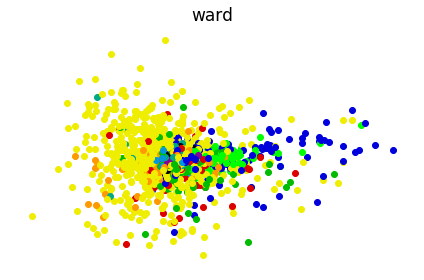

In [119]:
plot_clustering(X2, HC_10.labels_, "ward")

In [58]:
X.insert(3, "Cluster4", HC_10.labels_)
X['Cluster4'].value_counts()

0    1956
8     639
2     417
6     408
5     366
4     229
3     123
9     111
7     108
1      61
Name: Cluster4, dtype: int64

In [59]:
grouped4 = X["lable"].groupby(X['Cluster4'])
grouped4.all()

Cluster4
0          {'租金問題', '合約問題'}
1                    {None}
2          {'租金問題', '房屋問題'}
3    {'糾紛', '租金問題', '合約問題'}
4                    {None}
5            {'糾紛', '租金問題'}
6          {'租金問題', '合約問題'}
7                  {'租金問題'}
8          {'租金問題', '合約問題'}
9                  {'房屋問題'}
Name: lable, dtype: object

In [62]:
X.insert(4, "Cluster5", kmean_10.labels_)
X['Cluster5'].value_counts()

7    888
5    856
4    822
0    466
8    403
2    389
3    307
1    285
6      1
9      1
Name: Cluster5, dtype: int64

In [63]:
grouped4 = X["lable"].groupby(X['Cluster5'])
grouped4.all()

Cluster5
0                  {'房屋問題'}
1    {'糾紛', '租金問題', '合約問題'}
2                    {None}
3          {'租金問題', '房屋問題'}
4                  {'租金問題'}
5          {'租金問題', '合約問題'}
6                  {'環境問題'}
7          {'租金問題', '合約問題'}
8            {'糾紛', '租金問題'}
9          {'租金問題', '房屋問題'}
Name: lable, dtype: object

In [64]:
from matplotlib.ticker import NullFormatter

Isomap: 60 sec
MDS: 48 sec
SpectralEmbedding: 29 sec
t-SNE: 49 sec


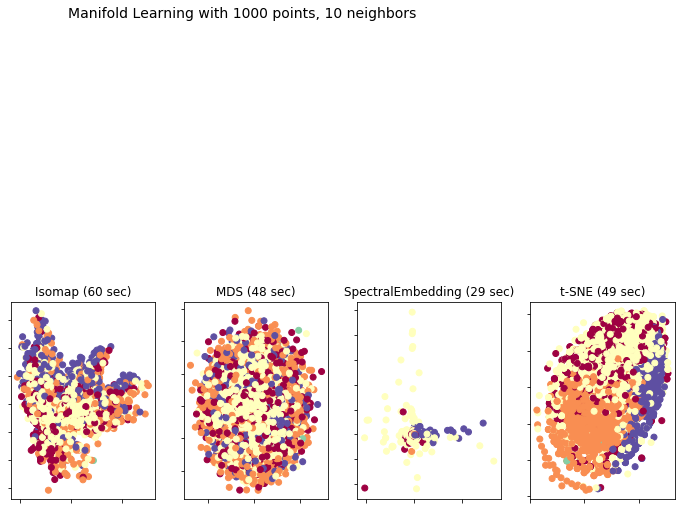

In [75]:
n_neighbors = 10
n_components = 2
fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i neighbors"
             % (n_neighbors), fontsize=14)

t0 = time.time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(train_vecs)
t1 = time.time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time.time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(train_vecs)
t1 = time.time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time.time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(train_vecs)
t1 = time.time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time.time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(train_vecs)
t1 = time.time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()